In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests 
from collections import Counter
import random
import decimal
import math
import random

In [76]:
##------------------------------Pegando os Dados-----------------------------------

#url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-12-21/2019-03-21/A307"
url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-01-01/2019-12-31/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp = requests.get(url, headers=headers)
df = None
df_temp = None
if resp.status_code != 200:
    print (resp.raise_for_status())
else:
    df = pd.DataFrame(resp.json())
    df.dropna(inplace=True)
    #df = df[df["TEM_MAX"].astype('float') ]
    df_temp = df[df['TEMP_MAX'].notnull()]
    df_temp = df[df['UMID_MED'].notnull()]
    
    df_temp = df[['TEMP_MAX', 'UMID_MED']]
    df_temp["id"] = df.index + 1 

    df_umid = df[df['UMID_MED'].notnull()]
    df_umid = df[['UMID_MED']]
    #df_umid["id"] = df.index + 1


<ipython-input-76-4c0a7404db43>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["id"] = df.index + 1


In [103]:

df_training_temp = None
df_training_temp_anomalie_edit = None
desvioPadraoTempTraining = 0
desvioPadraoUmidTraining = 0

desvioPadraoTempTest = 0
desvioPadraoUmidTest = 0

desvioPadrao = 0

def valorFinalTemperatura(df_training_temp_anomalie_edit, treino):
    valorMediaTemp = df_training_temp_anomalie_edit['TEMP_MAX'].sum()/df_training_temp_anomalie_edit.shape[0]
    desvioPadraoTemp = df_training_temp_anomalie_edit["TEMP_MAX"].std()
    if treino:
        desvioPadraoTempTraining = desvioPadraoTemp
    else:
        desvioPadraoTempTest = desvioPadraoTemp
    desvioPadraoEditadoTemp = 3 * desvioPadraoTemp
    valorFinalTemp = desvioPadraoEditadoTemp + valorMediaTemp
    valorFinalTemp = equacaoExponencial()
    return valorFinalTemp

def valorFinalUmidade(df_training_temp_anomalie_edit):
    valorMediaUmid = df_training_temp_anomalie_edit['UMID_MED'].sum()/df_training_temp_anomalie_edit.shape[0]
    desvioPadraoUmid = df_training_temp_anomalie_edit["UMID_MED"].std()
    desvioPadraoUmidTraining = desvioPadraoUmid
    desvioPadraoEditadoUmid = 3 * desvioPadraoUmid
    valorFinalUmid = desvioPadraoEditadoUmid + valorMediaUmid
    valorFinalUmid = equacaoExponencial()
    return valorFinalUmid

def qtdRowsTemp():
    count_row_temp = df_temp.shape[0]
    return count_row_temp

def equacaoExponencial():
    numberX = decimal.Decimal(random.randrange(-50, 50))/100
    eq = math.exp(3 * abs(numberX)) + 3
    return float(eq)

In [109]:
#------------------------------Tratando os Dados-----------------------------------

df_training_temp_anomalie_edit = df_temp.sample(n=30, random_state=1)

def dataTraining(percentOutliers, dbscan):
    
    qtd_training_temp = int(qtdRowsTemp()/3) * 2

    if dbscan:
        qtd_training_temp = qtdRowsTemp()

    df_training_temp = df_temp.sample(qtd_training_temp)

    count_training_temp = int((df_training_temp.shape[0] * percentOutliers) / 100)
        
    
    df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_training_temp_anomalie_edit.dropna(inplace=True)

    df_training_temp_anomalie_edit["TEMP_MAX"] = df_training_temp_anomalie_edit["TEMP_MAX"].astype(float)
    df_training_temp_anomalie_edit["UMID_MED"] = df_training_temp_anomalie_edit["UMID_MED"].astype(float)
    
    valorFinalTemp = valorFinalTemperatura(df_training_temp_anomalie_edit, True)
    valorFinalUmid = valorFinalUmidade(df_training_temp_anomalie_edit)

    df_training_temp_anomalie_edit["TEMP_MAX"] = df_training_temp_anomalie_edit["TEMP_MAX"].add(valorFinalTemp)
    df_training_temp_anomalie_edit["UMID_MED"] = df_training_temp_anomalie_edit["UMID_MED"].add(valorFinalUmid)

    df_training_temp_anomalie_edit.sort_index(inplace=True)
    
    #print (df_training_temp_anomalie_edit.shape)
    print (df_training_temp_anomalie_edit)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit])

    #Treino
    df_training_temp["TEMP_MAX"] = df_training_temp["TEMP_MAX"].astype(float)
    df_training_temp["UMID_MED"] = df_training_temp["UMID_MED"].astype(float)
    df_training_temp.dropna(inplace=True)
    df_training_temp.sort_index(inplace=True)
    #df_training_temp.sort_values(by=['TEMP_MAX'], ascending=True)
    df_training_temp = df_training_temp.drop(columns='id')

    #Teste
    count_test_temp = int((df_test_temp.shape[0] * percentOutliers) / 100)
    df_test_temp_anomalie_edit = df_test_temp.sample(n=count_test_temp, random_state=1)
    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_test_temp_anomalie_edit.dropna(inplace=True)
    
    df_test_temp_anomalie_edit["TEMP_MAX"] = df_test_temp_anomalie_edit["TEMP_MAX"].astype(float)
    df_test_temp_anomalie_edit["UMID_MED"] = df_test_temp_anomalie_edit["UMID_MED"].astype(float)
    
    valorFinalTemp = valorFinalTemperatura(df_test_temp_anomalie_edit, False)
    valorFinalUmid = valorFinalUmidade(df_test_temp_anomalie_edit)
    
    df_test_temp_anomalie_edit["TEMP_MAX"] = df_test_temp_anomalie_edit["TEMP_MAX"].add(valorFinalTemp)
    df_test_temp_anomalie_edit["UMID_MED"] = df_test_temp_anomalie_edit["UMID_MED"].add(valorFinalUmid)

    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit])
    
    df_test_temp["TEMP_MAX"] = df_test_temp["TEMP_MAX"].astype(float)
    df_test_temp["UMID_MED"] = df_test_temp["UMID_MED"].astype(float)
    df_test_temp.sort_index(inplace=True)

    df_test_temp.dropna(inplace=True)
    df_test_temp = df_test_temp.drop(columns='id')
    desvioPadrao = (desvioPadraoTempTraining + desvioPadraoUmidTraining) / 2
    return df_training_temp, df_test_temp

In [110]:
#import random

taxaContaminacao = 15
dfs = dataTraining(taxaContaminacao, True)
df_training_temp = dfs[0]
df_test_temp = dfs[1]

      TEMP_MAX   UMID_MED   id
0    43.732787  47.332787    1
13   42.232787  58.532787   14
23   41.932787  52.432787   24
64   42.332787  56.632787   65
184  37.432787  54.232787  185
210  37.432787  55.132787  211
225  39.532787  52.032787  226
266  41.032787  50.132787  267
290  40.232787  56.032787  291
291  41.732787  49.632787  292
315  41.232787  48.632787  316
402  39.432787  70.232787  403
446  37.432787  82.232787  447
478  40.932787  57.132787  479
482  40.432787  56.932787  483
496  40.332787  62.632787  497
501  38.432787  66.432787  502
512  39.132787  58.732787  513
528  36.432787  74.432787  529
548  39.732787  58.432787  549
552  38.632787  54.632787  553
563  35.132787  67.532787  564
590  37.532787  62.632787  591
601  38.632787  56.632787  602
606  38.032787  60.632787  607
609  41.032787  51.832787  610
611  39.732787  54.632787  612
653  39.532787  52.332787  654
676  42.432787  47.932787  677
690  41.032787  48.732787  691


<ipython-input-103-f906378f122b>:12: RuntimeWarning: invalid value encountered in double_scalars
  valorMediaTemp = df_training_temp_anomalie_edit['TEMP_MAX'].sum()/df_training_temp_anomalie_edit.shape[0]
<ipython-input-103-f906378f122b>:24: RuntimeWarning: invalid value encountered in double_scalars
  valorMediaUmid = df_training_temp_anomalie_edit['UMID_MED'].sum()/df_training_temp_anomalie_edit.shape[0]



Outliers encontrados: 
(25, 2)
      TEMP_MAX   UMID_MED
0    43.732787  47.332787
13   42.232787  58.532787
26   35.800000  64.600000
40   29.300000  80.900000
336  32.800000  74.300000
337  26.400000  80.100000
338  29.500000  77.800000
402  39.432787  70.232787
446  37.432787  82.232787
459  32.000000  74.500000
496  40.332787  62.632787
501  38.432787  66.432787
522  26.400000  68.900000
528  36.432787  74.432787
554  25.700000  69.800000
555  25.900000  64.400000
563  35.132787  67.532787
564  26.300000  59.900000
583  26.300000  69.700000
590  37.532787  62.632787
692  40.100000  33.000000
699  38.400000  31.300000
700  39.000000  27.400000
701  39.300000  27.700000
705  38.600000  30.000000


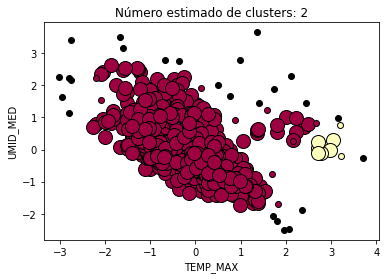

In [111]:
#------------------------------Implementando o DBSCAN-----------------------------------
def dbscan_part1(df, eps, min_samples):
    #X = np.array([ [1, 2], [2, 2], [7, 6], [28, 7], [2, 3], [25, 8], [3, 2],[1, 3],[1.1, 2],[1.2, 2],[1.3, 2],[1.4, 2]])
    X = np.array(df)
    X = StandardScaler().fit_transform(df)
    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='brute',p=100).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_

    outliers = df[db.labels_ == -1]

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Preto usado para ruído
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    print ()
    print('Outliers encontrados: ')
    print (outliers.shape)
    print (outliers)
    
    plt.title('Número estimado de clusters: %d' % n_clusters_)
    plt.xlabel("TEMP_MAX")
    plt.ylabel("UMID_MED")
    plt.show()

eps = 0.5
min_samples = 5
#print (df_training_temp.shape)
#print (df_training_temp)

#x = np.array([[10, 50], [12, 50], [48, 70]], np.float)

#df=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED'])
#df_training_temp = pd.concat([df, df_training_temp]).drop_duplicates(keep=False)
#df_training_temp = np.array([[10, 20], [12, 21], [10, 23], [57,75]], np.float)

dbscan_part1(df_training_temp, eps, min_samples)


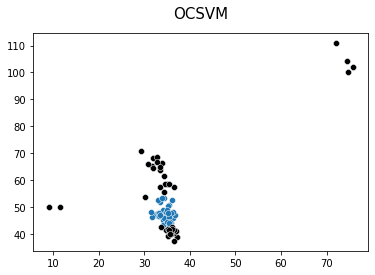

In [19]:
from sklearn.svm import OneClassSVM
import seaborn as sns

x = np.array([[10, 50], [12, 50]], np.float)
df=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED'])
df_training_temp = pd.concat([df, df_training_temp]).drop_duplicates(keep=False)


X = np.array(df_training_temp)
X, _ = make_blobs(n_samples=df_training_temp.shape[0], centers=X, cluster_std=0.4,random_state=None)

ocsvm = OneClassSVM(kernel='rbf', degree=3, gamma='scale', nu=0.5, coef0=0.0,tol=0.001,
                    shrinking=True,cache_size=10,
                    verbose=False,max_iter=-1).fit(X)
pred = ocsvm.predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

sns.scatterplot(x=X[:,0], y=X[:,1])
sns.scatterplot(x=outlier_values[:,0], 
                y=outlier_values[:,1], color='black')
plt.title("OCSVM", fontsize=15, pad=15)
plt.savefig("One-Class SVM Detection.png", dpi=80)

Text(0, 0.5, 'UMID_MED')

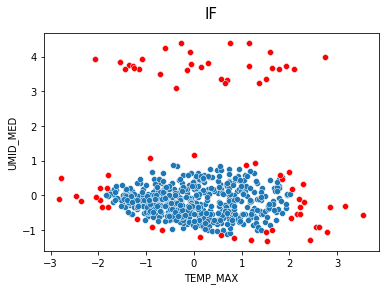

In [26]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns

x = np.array([[10, 50], [12, 50]], np.float)
df=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED'])
df_training_temp = pd.concat([df, df_training_temp]).drop_duplicates(keep=False)

X = np.array(df_training_temp)

iforest = IsolationForest(n_estimators=300, max_samples=df_training_temp.shape[0], 
                          warm_start=False,
                          contamination='auto', max_features=1.0, 
                          bootstrap=False, n_jobs=None, random_state=None)

pred = iforest.fit_predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

sc=StandardScaler()
X_scaled = sc.fit_transform(X)
outlier_values_scaled = sc.transform(outlier_values)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
outlier_values_pca = pca.transform(outlier_values_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
sns.scatterplot(x=outlier_values_pca[:,0], 
                y=outlier_values_pca[:,1], color='r')
plt.title("IF", fontsize=15, pad=15)
plt.xlabel("TEMP_MAX")
plt.ylabel("UMID_MED")

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

X_test = np.array(df_test_temp)
X_train = np.array(df_training_temp)

# fit the model
clf = svm.OneClassSVM(nu=0.5, kernel="rbf", gamma='scale').fit(X_train)
y_pred_train = clf.predict(X_train)
print (y_pred_train)
print ()
y_pred_test = clf.predict(X_test)
print (y_pred_test)

'''
outlier_index = np.where(y_pred_train==-1)
outlier_values = X_train[outlier_index]
print (outlier_values)
'''


[ 1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1 -1
 -1 -1  1 -1  1 -1  1  1 -1  1 -1  1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1
 -1  1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1
 -1  1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1  1 -1  1 -1
  1 -1  1  1  1  1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1
  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1  1
 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1 -1
  1  1 -1  1  1  1 -1 -1  1 -1  1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1
  1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1
 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1
 -1  1  1 -1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1  1 -1  1
  1 -1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1  1  1  1

'\noutlier_index = np.where(y_pred_train==-1)\noutlier_values = X_train[outlier_index]\nprint (outlier_values)\n'